# Fetch dataset

In [1]:
import boto3

In [2]:
dynamodb = boto3.resource('dynamodb')

In [3]:
table = dynamodb.Table('car_table')

In [4]:
response = table.scan()
data = response['Items']

while 'LastEvaluatedKey' in response:
    response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
    data.extend(response['Items'])

In [5]:
len(data)

1728

# Dataset formatting

In [49]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [50]:
rawDataset = np.array([list(d.values())[1:] for d in data])

In [51]:
enc = OrdinalEncoder()
enc.fit(rawDataset)

OrdinalEncoder()

In [52]:
dataset = enc.transform(rawDataset)

In [53]:
attributes = list(data[0].keys())[1:]

In [54]:
features = attributes[:5] + attributes[6 :]
X = dataset[:,[0,1,2,3,4,6]]
y = dataset[:,5]

In [55]:
features

['buying', 'maint', 'safety', 'lug_boot', 'persons', 'doors']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model fit

In [57]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
import graphviz 

In [58]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [59]:
clf = clf.fit(X_train, y_train)

In [60]:
clf.score(X_test, y_test)

0.9913294797687862

In [61]:
scores = cross_val_score(clf, X, y, cv=5)

In [62]:
scores

array([0.95953757, 0.97687861, 0.97976879, 0.97971014, 0.9884058 ])

# Model visualization

In [63]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=features,
                     class_names='class',
                     filled=True, rounded=True,  
                     special_characters=True)  

In [64]:
graph = graphviz.Source(dot_data)

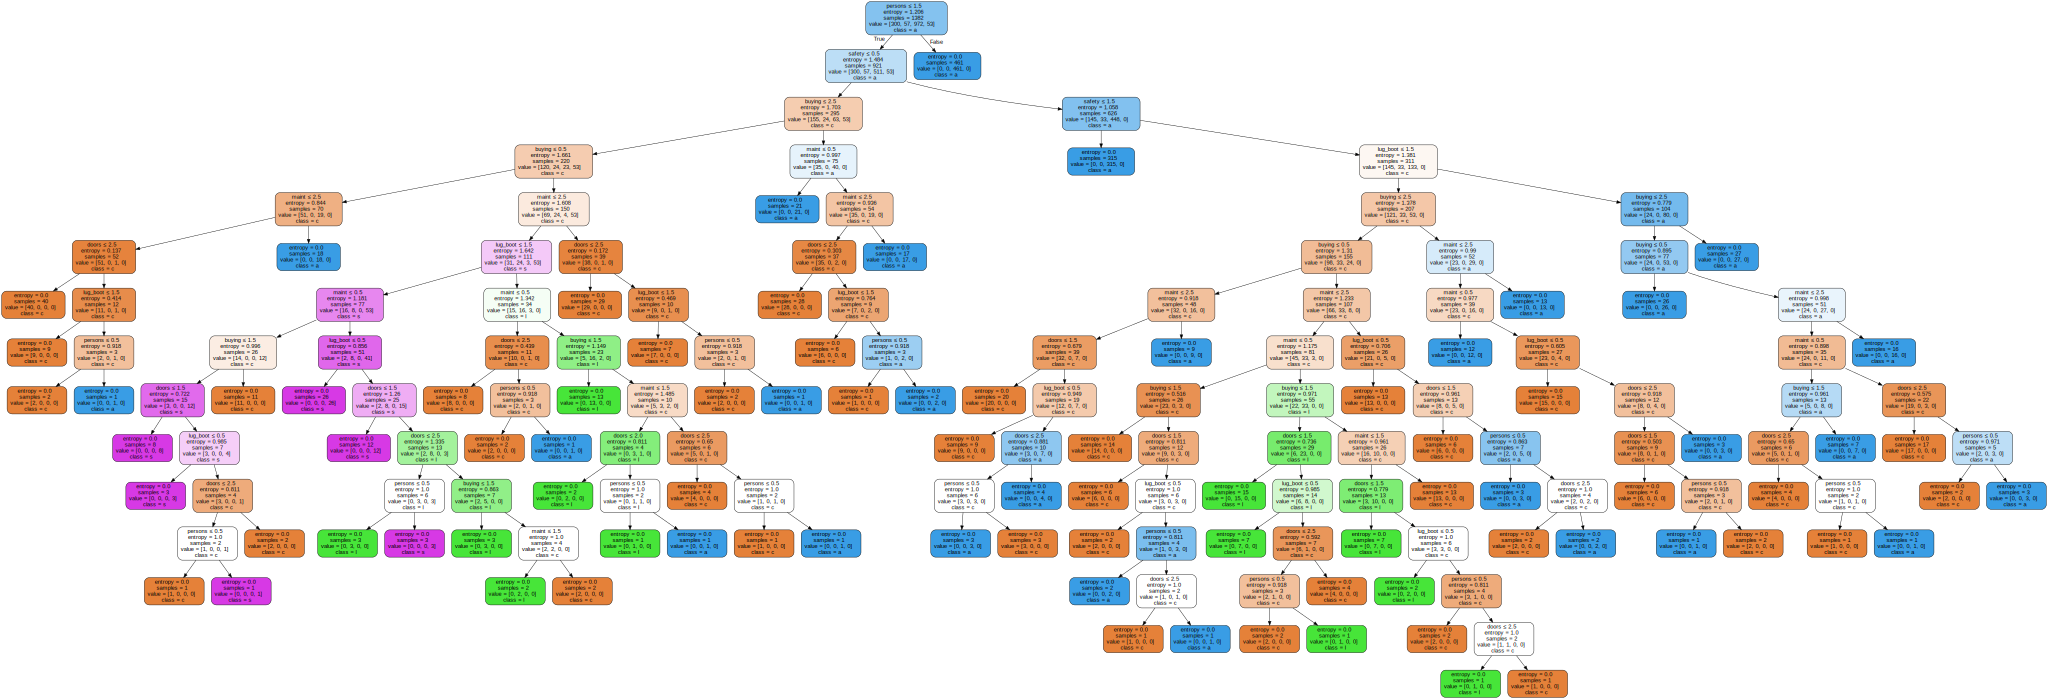

In [65]:
graph

# Create new instances and classify

In [107]:
def random_sample():
    return [np.random.choice(np.unique(X[:,i])) for i in range(len(features))]

In [133]:
synthethic_data = np.array([random_sample() for i in range(100)], dtype=np.uint)

In [134]:
yPredictions = clf.predict(synthethic_data)

In [137]:
array([yPredictions], dtype=np.uint)

array([[2, 0, 2, 2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 2,
        0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2,
        2, 2, 0, 2, 2, 0, 3, 1, 2, 2, 0, 2, 3, 2, 0, 0, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0]], dtype=uint64)

In [141]:
predictions = np.append(synthethic_data, array([yPredictions],dtype=np.uint).T, axis=1)

# Predictions export

In [29]:
import sqlite3

In [30]:
con = sqlite3.connect('predictions.db')

In [31]:
cur = con.cursor()

In [33]:
attributes

['buying', 'maint', 'safety', 'lug_boot', 'persons', 'class', 'doors']

In [37]:
cur.execute('''CREATE TABLE Predictions
    (buying INT,maint INT,safety INT,lug_boot INT,persons INT,doors INT,class INT)''')

In [146]:
predList = predictions[0].tolist()

In [149]:
",".join(map(str,predList))

'1,0,1,2,0,2,2'

In [150]:
def insert_statement(prediction):
    prefix = "INSERT INTO Predictions VALUES ("
    predList = prediction.tolist()
    predStr = ",".join(map(str,predList))
    postFix = ")"
    return prefix + predStr + postFix

In [151]:
insert_statement(predictions[0])

'INSERT INTO Predictions VALUES (1,0,1,2,0,2,2)'

In [152]:
for i in range(len(predictions)):
    cur.execute(insert_statement(predictions[i]))

In [153]:
con.commit()

In [154]:
con.close()

# Visualize db contents

In [155]:
con = sqlite3.connect('predictions.db')
cur = con.cursor()

In [156]:
for row in cur.execute('SELECT * FROM Predictions'):
    print(row)

(1, 0, 1, 2, 0, 2, 2)
(3, 2, 2, 1, 1, 2, 0)
(1, 2, 1, 1, 0, 3, 2)
(2, 0, 0, 0, 2, 1, 2)
(1, 0, 0, 0, 1, 1, 3)
(2, 3, 1, 0, 0, 3, 2)
(0, 0, 1, 2, 0, 1, 2)
(1, 2, 0, 0, 0, 1, 3)
(2, 3, 1, 1, 0, 1, 2)
(3, 2, 0, 0, 0, 0, 0)
(0, 3, 0, 0, 1, 1, 2)
(2, 2, 1, 0, 1, 0, 2)
(1, 2, 1, 2, 1, 1, 2)
(3, 0, 1, 2, 1, 2, 2)
(1, 2, 1, 1, 0, 1, 2)
(3, 3, 1, 0, 1, 0, 2)
(1, 3, 0, 0, 0, 2, 0)
(3, 2, 1, 1, 2, 0, 2)
(0, 2, 2, 0, 2, 0, 2)
(3, 3, 0, 1, 2, 0, 2)
(1, 0, 1, 0, 1, 3, 2)
(1, 0, 1, 1, 0, 0, 2)
(1, 0, 0, 1, 2, 0, 2)
(0, 3, 2, 2, 2, 3, 2)
(0, 0, 2, 1, 1, 3, 2)
(2, 2, 2, 2, 2, 1, 2)
(2, 3, 0, 1, 2, 3, 2)
(3, 1, 1, 1, 0, 1, 2)
(2, 0, 1, 2, 2, 2, 2)
(3, 0, 1, 2, 1, 2, 2)
(3, 2, 0, 2, 2, 3, 2)
(2, 1, 0, 2, 0, 1, 1)
(0, 0, 1, 2, 2, 1, 2)
(2, 1, 1, 2, 1, 1, 2)
(3, 1, 1, 1, 1, 2, 2)
(2, 0, 0, 2, 1, 0, 0)
(1, 3, 2, 0, 1, 1, 0)
(1, 2, 0, 2, 1, 1, 1)
(1, 1, 0, 1, 0, 2, 1)
(1, 1, 0, 0, 2, 3, 2)
(0, 1, 2, 1, 2, 1, 2)
(3, 1, 2, 1, 2, 1, 2)
(3, 3, 1, 1, 2, 3, 2)
(1, 3, 1, 2, 2, 0, 2)
(2, 0, 2, 0, 1, 3, 0)
(0, 0, 0, 